## TalkingData AdTracking Fraud Detection Challenge

## １. 質問または問題の定義

このノートの目的は、モバイルアプリ広告をクリックした後にユーザーがアプリをダウンロードするかどうかを予測することです。
概要はここから(https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection) 確認できます。

## ２.データセットを取得

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import datetime
import os
plt.style.use('seaborn-whitegrid')
%matplotlib inline
from pandas.core.common import _values_from_object
from pandas.core.config import get_option
sns.set(rc={'figure.figsize':(12,5)});
plt.figure(figsize=(12,5));

まず、PandasDataFrameの中に学習データセットとテストデータセットを取得します。

In [2]:
df_train = pd.read_csv('../input/train_sample.csv',nrows=50000000)
df_test = pd.read_csv('../input/test.csv')

#### 各変数の詳細は以下の通りです。
- ip：アプリ広告をクリックしたユーザーのIPアドレス
- app：アプリ広告ID
- device：ユーザーのモバイルデバイスタイプ ID
- os：ユーザーのモバイルのOSバージョンID
- channel：アプリ広告のクリック流入経路ID
- click_time：クリックのタイムスタンプ（UTC）
- attributed_time：クリック後、アプリをダウンロードしたタイムスタンプ（UTC）
- is_attributed：アプリのダウンロード有無のバイナリ形式

In [3]:
df_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
ip                 100000 non-null int64
app                100000 non-null int64
device             100000 non-null int64
os                 100000 non-null int64
channel            100000 non-null int64
click_time         100000 non-null object
attributed_time    227 non-null object
is_attributed      100000 non-null int64
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


'click_time'、'attributed_time'にはobjectデータ（タイムスタンプ形式）、その他は数値データが格納されています。  
また、attributed_timeに欠損値があることがわかります。 

In [5]:
df_test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


テストデータには学習データにはない'click_id'がある一方で、'attributed_time'と'is_attributed'が削除されていることが確認できます。

## 3.データセットの前処理

- 以下は'click_time'のタイムスタンプ形式からhourを抽出し、データセットに'hour'の特徴量を作成し追加しています。

In [6]:
df_train['click_hour'] = pd.to_datetime(df_train.click_time).dt.hour.astype('int8')
# df_train_del=df_train.drop(['click_time', 'attributed_time'], axis=1)
df_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_hour
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,9
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,13
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,18
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,4
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,9


In [7]:
df_test['click_hour'] = pd.to_datetime(df_test.click_time).dt.hour.astype('int8')
df_test.head()

,click_id,ip,app,device,os,channel,click_time,click_hour
0,0,5744,9,1,3,107,2017-11-10 04:00:00,4
1,1,119901,9,1,3,466,2017-11-10 04:00:00,4
2,2,72287,21,1,19,128,2017-11-10 04:00:00,4
3,3,78477,15,1,13,111,2017-11-10 04:00:00,4
4,4,123080,12,1,13,328,2017-11-10 04:00:00,4


### ４. データ分析

では、時系列でのクリック数やダウンロード数を見ていきましょう。

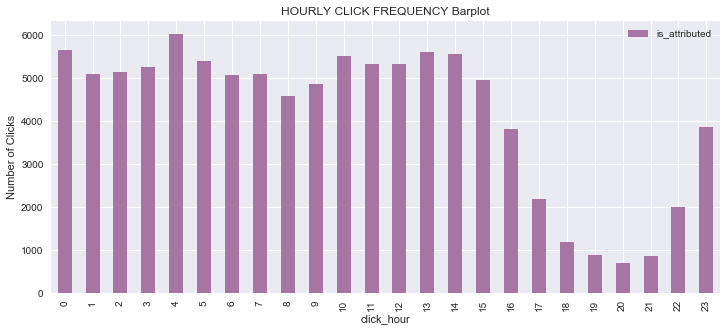

In [8]:
#extract hour as a feature
#df_train['click_hour']=df_train['click_time'].dt.hour
df_train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(kind='bar', color='#a675a1')
plt.title('HOURLY CLICK FREQUENCY Barplot');
plt.ylabel('Number of Clicks');

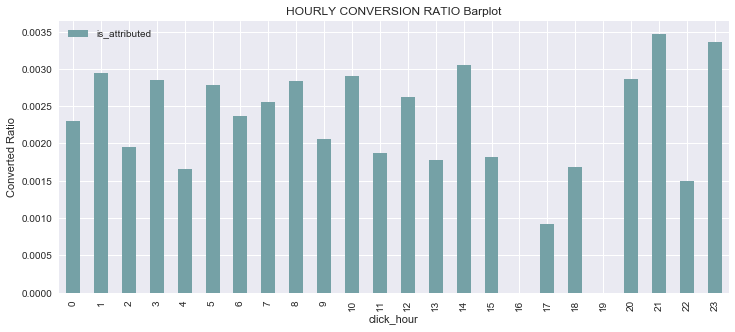

In [9]:
df_train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot(kind='bar', color='#75a1a6')
plt.title('HOURLY CONVERSION RATIO Barplot');
plt.ylabel('Converted Ratio');

更に折れ線グラフで二つの図を重ねて表示します。

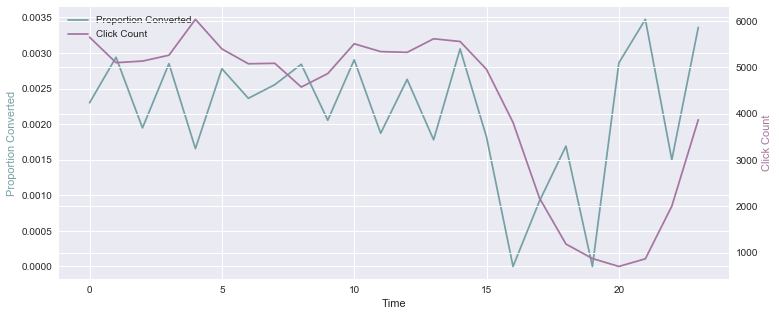

In [10]:
group = df_train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).mean()
x = group['click_hour']
ymean = group['is_attributed']
group = df_train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).count()
ycount = group['is_attributed']

fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Time")
host.set_ylabel("Proportion Converted")
par1.set_ylabel("Click Count")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, ymean, color=color1,label="Proportion Converted")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')

以上からわかることは、
- クリック数とコンバージョン率の推移が、だいたい14時まで似ているが、その後は22時まで大きく乖離してことがわかります。
- 不正クリックは時間毎に一定の割合ではない可能性が高いと判断できる。  一定の時間帯で不正クリックが行われている可能性も考えられます。

そこで時間毎のコンバーション率に注目して、特徴量に加える方法を採用することにします。まず時間毎のコンバージョン率を計算して時間順にndarray型に変換します。

In [11]:
df_train[['click_hour','is_attributed']].groupby(['click_hour']).mean().values.T

array([[ 0.00229926,  0.00293945,  0.00194666,  0.00284954,  0.0016559 ,
         0.00277778,  0.00236267,  0.00255453,  0.00284091,  0.00205465,
         0.00290328,  0.00187196,  0.00262861,  0.00177968,  0.003057  ,
         0.00181561,  0.        ,  0.00091912,  0.00169062,  0.        ,
         0.00286123,  0.00347222,  0.0014985 ,  0.00335917]])

ndarrayに時刻をインデックスにしてmapメソッドで特徴量'conversion_ratio_hour'を追加します。

In [12]:
mapping={ 0:0.00229926, 1: 0.00293945, 2: 0.00194666, 3: 0.00284954, 4: 0.0016559 ,
        5: 0.00277778, 6: 0.00236267, 7: 0.00255453, 8: 0.00284091, 9: 0.00205465,
        10: 0.00290328, 11: 0.00187196, 12: 0.00262861, 13: 0.00177968, 14: 0.003057  ,
         15:0.00181561, 16: 0.        , 17: 0.00091912, 18: 0.00169062, 19: 0.        ,
        20: 0.00286123, 21: 0.00347222, 22: 0.0014985 ,23: 0.00335917}
#for i in range(24):
#    
#
df_train["conversion_ratio_hour"]=df_train["click_hour"].map(mapping)


In [13]:
df_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_hour,conversion_ratio_hour
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,9,0.002055
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,13,0.001780
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,18,0.001691
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,4,0.001656
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,9,0.002055


テストデータにも同様に特徴量'conversion_ratio_hour'を追加しています。

In [14]:
mapping={ 0:0.00229926, 1: 0.00293945, 2: 0.00194666, 3: 0.00284954, 4: 0.0016559 ,
        5: 0.00277778, 6: 0.00236267, 7: 0.00255453, 8: 0.00284091, 9: 0.00205465,
        10: 0.00290328, 11: 0.00187196, 12: 0.00262861, 13: 0.00177968, 14: 0.003057  ,
         15:0.00181561, 16: 0.        , 17: 0.00091912, 18: 0.00169062, 19: 0.        ,
        20: 0.00286123, 21: 0.00347222, 22: 0.0014985 ,23: 0.00335917}

df_test["conversion_ratio_hour"]=df_test["click_hour"].map(mapping)

## ５. 問題のモデル化、予測、そしてソリューション

- 学習用データ（X_train、Y_train）と予測用データ（X_test）を作成します。
- 回帰分析モデルはLightGBMを採用します。

In [15]:
# trainデータからclick_time、attributed_time、'click_hour'、'is_attributedを削除し、X_trainに格納
X_train = df_train.drop(['click_time','click_hour','attributed_time','is_attributed'], axis=1)
# trainデータからis_attributedを抽出し、Y_trainに格納
Y_train = df_train['is_attributed']

In [16]:
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

X = X_train
y = Y_train

x_train, x_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0)

lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

# LightGBM parameters
params = {
        #'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'auc'},
        'num_class': 1,
        'learning_rate': 0.1,
        #'num_leaves': 23,
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)★
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.★
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)★
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'min_data_in_leaf': 1,
        'num_iteration': 100,
        #'reg_alpha': 0.99,  # L1 regularization term on weights
        #'reg_lambda': 0.9,  # L2 regularization term on weights
        'nthread': 8,
        'verbose': 1
}

# train
gbm = lgb.train(params,
            lgb_train,
            #num_boost_round=50,
            num_boost_round=3000,
            valid_sets=lgb_eval,
            #early_stopping_rounds=10
            early_stopping_rounds=50)


/Users/okunagatatsuya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.499662
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's auc: 0.722217
[3]	valid_0's auc: 0.739803
[4]	valid_0's auc: 0.863483
[5]	valid_0's auc: 0.97497
[6]	valid_0's auc: 0.97532
[7]	valid_0's auc: 0.975051
[8]	valid_0's auc: 0.980229
[9]	valid_0's auc: 0.979468
[10]	valid_0's auc: 0.978455
[11]	valid_0's auc: 0.977372
[12]	valid_0's auc: 0.97738
[13]	valid_0's auc: 0.978425
[14]	valid_0's auc: 0.976374
[15]	valid_0's auc: 0.980387
[16]	valid_0's auc: 0.980216
[17]	valid_0's auc: 0.979349
[18]	valid_0's auc: 0.97917
[19]	valid_0's auc: 0.978377
[20]	valid_0's auc: 0.976776
[21]	valid_0's auc: 0.976111
[22]	valid_0's auc: 0.978195
[23]	valid_0's auc: 0.977183
[24]	valid_0's auc: 0.976764
[25]	valid_0's auc: 0.97809
[26]	valid_0's auc: 0.97809
[27]	valid_0's auc: 0.979009
[28]	valid_0's auc: 0.978844
[29]	valid_0's auc: 0.980397
[30]	valid_0's auc: 0.98002
[31]	valid_0's auc: 0.980539
[32]	valid_0's auc: 0.980316
[33]	valid_0's auc: 0.9805

## ６. 最終的な解決方法を視覚化、提示

クロスバリデーション（交差検証）をして、モデルのスコアのうち、最高値を表示しています。

In [17]:
d_train = lgb.Dataset(X_train, label=Y_train)
cv_results = lgb.cv(params, d_train, nfold=5)

print('Best CV score:', max(cv_results['auc-mean']))

Best CV score: 0.96135514713


### テストデータで予測し、submissionファイルを作成

In [18]:
#testデータから'click_time', 'click_id'を削除し、X_testに格納
X_test  = df_test.drop(['click_time','click_id','click_hour'], axis=1)
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [19]:
submission = pd.DataFrame({
       'click_id': df_test['click_id'],
       'is_attributed': y_pred
})
submission.to_csv('submission2.csv', index=False)

### 反省＆改善
- ipごとの挙動に、より焦点を絞った特徴量を豊富に作成することに挑戦してみる。
- グリッドサーチやランダムサーチで、パラメータをチューニングして精度を上げる。
- 複数のモデルによるアンサンブル学習で精度を上げる。